<a href="https://colab.research.google.com/github/Aravindan98/Le-Mans-Thesis/blob/main/DGM/DGM_transformed_GBM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SCRIPT FOR SOLVING THE FOKKER-PLANCK EQUATION FOR ORNSTEIN-UHLENBECK PROCESS 
# WITH RANDOM (NORMALLY DISTRIBUTED) STARTING VALUE (see p.54)

#%% import needed packages

%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#%% Parameters

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim], initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,t,x):
        '''            
        Args:
            t: sampled time inputs 
            x: sampled space inputs

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        X = tf.concat([t,x],1)
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result

TensorFlow 1.x selected.


### I should know the initial distribution. Need to look into it.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7766185/

In [ ]:
# GBM process parameters 
m = 0
s = 1 

# mean and standard deviation for (normally distributed) process starting value
alpha = 5
beta = 1

# terminal time 
T = 1.0

# bounds of sampling region for space dimension, i.e. sampling will be done on
# [multiplier*Xlow, multiplier*Xhigh]
Xlow = 0.01
Xhigh = 50
x_multiplier = 1.0
t_multiplier = 1.5

# neural network parameters
num_layers = 5
nodes_per_layer = 20
learning_rate = 0.001

# Training parameters
sampling_stages = 75    # number of times to resample new time-space domain points
steps_per_sample = 20    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_t = 5
nSim_x_interior = 50
nSim_x_initial = 50

# Save options
saveOutput = True
saveName   = 'FokkerPlanck'
saveFigure = True
figureName = 'fokkerPlanck_density.png'

Need to change the following function accordingly.

## $$dX_t=\mu X_tdt+\sigma X_t  dW_t$$
## $$X_t=x_0e^{(\mu-\frac{\sigma^2}{2})t+\sigma W_t}$$
Initial Condition:
$$p(0,x)=\delta(x-x_0)$$

In [ ]:
#%% GBM Simulation function
def simulateGBM_GaussianStart(alpha, beta, m, s, n_sim, T):
    ''' Simulate end point of Ornstein-Uhlenbeck process with normally 
        distributed random starting value.
    
    Args:
        alpha: mean of random starting value
        beta:  standard deviation of random starting value
        m: drift coeff 
        s: diffusion coeff
        n_sim:  number of simulations
        T:     terminal time        
    '''  
        
    # simulate initial point based on normal distribution
    x_0 = np.random.normal(alpha,beta,n_sim)
    #plt.hist(x_0, 100, density=True, align='mid')
    t= T*np.ones_like(x_0)

    mu = np.log(x_0) + (m-(s**2/2))*t
    sigma = np.sqrt((s**2)*t)

    #print(mu, sigma)   
    X_T = np.random.lognormal(mu, sigma, n_sim)
    #fig, (ax1, ax2) = plt.subplots(2)
    #ax1.hist(x_0, 100, density=True, align='mid')
    #count, bins, ignored = ax2.hist(X_T, 100, density=True, align='mid')
    #x = np.linspace(min(bins), max(bins), n_sim)
    #pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/(x * sigma * np.sqrt(2 * np.pi)))
    #ax2.plot(x, pdf, linewidth=2, color='r')
    #ax2.axis('tight')
    #ax2.show()

    return X_T, mu, sigma
'''
n_sim = 10000
t=0.001
alpha = 100
beta = 0.0001
m = 0 
s = 1
'''
#s, pdf = 
#simulateGBM_GaussianStart(alpha, beta, m, s, n_sim, t)
#print(alpha, beta, m, s, n_sim, 2)

    

'''
n_sim = 1000
x_0 = np.random.normal(50,1,n_sim)

m = 0 
s = 1
t = 1
t= t*np.ones_like(x_0)

mu = np.log(x_0) + (m-s**2/2)*t
sigma = np.sqrt((s**2)*t)

#print(mu, sigma)

s = np.random.lognormal(mu, sigma, n_sim)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 1000, density=True, align='mid')
x = np.linspace(min(bins), max(bins), n_sim)

#print(x)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))


plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()
'''

"\nn_sim = 1000\nx_0 = np.random.normal(50,1,n_sim)\n\nm = 0 \ns = 1\nt = 1\nt= t*np.ones_like(x_0)\n\nmu = np.log(x_0) + (m-s**2/2)*t\nsigma = np.sqrt((s**2)*t)\n\n#print(mu, sigma)\n\ns = np.random.lognormal(mu, sigma, n_sim)\n\nimport matplotlib.pyplot as plt\ncount, bins, ignored = plt.hist(s, 1000, density=True, align='mid')\nx = np.linspace(min(bins), max(bins), n_sim)\n\n#print(x)\npdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))\n       / (x * sigma * np.sqrt(2 * np.pi)))\n\n\nplt.plot(x, pdf, linewidth=2, color='r')\nplt.axis('tight')\nplt.show()\n"

In [ ]:
#%% Sampling function - randomly sample time-space pairs 
'''
Xlow = 0.01
Xhigh = 100
T =1 
x_multiplier = 2.0
t_multiplier = 1.5
'''
def sampler(nSim_t, nSim_x_interior, nSim_x_initial):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_t:          number of (interior) time points to sample
        nSim_x_interior: number of space points in the interior of the function's domain to sample 
        nSim_x_initial:  number of space points at initial time to sample (initial condition)
    ''' 
    #fig, (ax1, ax2, ax3) = plt.subplots(3)
    # Sampler #1: domain interior
    t = np.random.uniform(low=0, high=T*t_multiplier, size=[nSim_t, 1])
    x_interior = np.random.uniform(low=Xlow*x_multiplier, high=Xhigh*x_multiplier, size=[nSim_x_interior, 1])
    
    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem 
    
    # Sampler #3: initial/terminal condition
    x_initial = np.random.uniform(low=alpha-4, high=alpha+4, size = [nSim_x_initial, 1])
    #ax1.hist(t, 100, density=True, align='mid')
    #ax2.hist(x_interior, 100, density=True, align='mid')
    #ax3.hist(x_initial, 100, density=True, align='mid')
    
    return t, x_interior, x_initial

#print(sampler(59,50,50))     

# $$p_t+(\mu-\sigma^2)p+(\mu-2\sigma^2)xp_x-\frac{\sigma^2}{2}x^2p_{xx}=0$$
## applying transformation $p(x,t)=\frac{e^{-u(x,t)}}{c(t)}$ where, $c(t)$ is the normalizing factor 
## (i.e $\int e^{-u(x,t)}dx$)
# $$-u_t+\psi+(\mu-\sigma^2)-(\mu-2\sigma^2)xu_x-\frac{\sigma^2}{2}x^2(u_x^2-u_{xx})=0$$

## $\psi = \frac{\int u_te^{-u(x,t)}dx}{\int e^{-u(x,t)}dx}$

## applying another transformation:  $ln(x)=y$

## $-u_t(y,t) + \tilde{\psi} + (\mu-\sigma^2)-(\mu-2\sigma^2)u_y-\frac{\sigma^2}{2}(u_y^2+u_y-u_{yy}) = 0$

# where, $\tilde{\psi} = \frac{\int u_te^{-u(y,t)}e^ydy}{\int e^{-u(y,t)}e^ydy}$




In [ ]:
#%% Loss function for Fokker-Planck equation
import tensorflow_probability as tfp
tfd = tfp.distributions

def loss(model, t, x_interior, x_initial, nSim_t, alpha, beta, m, s):
    ''' Compute total loss for training.
        NOTE: the loss is based on the PDE satisfied by the negative-exponential
              of the density and NOT the density itself, i.e. the u(t,x) in 
              p(t,x) = exp(-u(t,x)) / c(t)
              where p is the density and c is the normalization constant
    
    Args:
        model:      DGM model object
        t:          sampled (interior) time points
        x_interior: sampled space points in the interior of the function's domain
        x_initial:  sampled space points at initial time
        nSim_t:     number of (interior) time points sampled (size of t)
        alpha:      mean of normal distribution for process starting value
        beta:       standard deviation of normal distribution for process starting value
    ''' 
    
    # Loss term #1: PDE
    
    # initialize vector of losses
    losses_u = []
    
    # for each simulated interior time point
    for tIndex in range(nSim_t):
        
        # make vector of current time point to align with simulated interior space points   
        curr_t = t[tIndex]
        t_vector = curr_t * tf.ones_like(x_interior)
        
        y_interior = tf.log(x_interior)

        # compute function value and derivatives at current sampled points
        u    = model(t_vector, y_interior)
        u_t  = tf.gradients(u, t_vector)[0]
        u_y  = tf.gradients(u, y_interior)[0]
        u_yy = tf.gradients(u_y, y_interior)[0]
        
        # psi function: normalized and exponentiated neural network
        # note: sums are used to approximate integrals (importance sampling)
        psi_denominator = tf.reduce_sum(tf.exp(-u)*x_interior)
        psi_bar = tf.reduce_sum(u_t*tf.exp(-u)*x_interior) / psi_denominator

        # PDE differential operator
        # NOTE: EQUATION IN DOCUMENT IS INCORRECT - EQUATION HERE IS CORRECT
        #diff_f = -u_t - kappa + kappa*(x_interior- theta)*u_x - 0.5*sigma**2*(-u_xx + u_x**2) + psi
        #diff_f = p_t + (m-(s)**2)*p + (m-2*(s)**2)*x_interior*p_x - (s**2/2)*((x_interior**2)*p_xx)
        #diff_f = -u_t + psi + (m-s**2) - (m-2*s**2)*x_interior*u_x - (s**2/2)*(x_interior**2)*(u_x**2 - u_xx)
        diff_f = -u_t + psi_bar + (m-s**2) - (m-2*s**2)*u_y - (s**2/2)*(u_y**2 + u_y - u_yy)
        
        # compute L2-norm of differential operator and attach to vector of losses
        currLoss = tf.reduce_mean(tf.square(diff_f)) 
        losses_u.append(currLoss)
    
    # average losses across sample time points 
    L1 = tf.add_n(losses_u) / nSim_t
    
    # Loss term #2: boundary condition
        # no boundary condition for this problem
    #p = model(t[-1,1]*tf.ones_like(x_initial), x_initial)
    #L2 = tf.reduce_mean(tf.square(p))
    # Loss term #3: initial condition
    
    # compute negative-exponential of neural network-implied pdf at t = 0
    # i.e. the u in p = e^[-u(t,x)] / c(t)
    fitted_pdf = model(0*tf.ones_like(x_initial), tf.log(x_initial))
    
    # target pdf - normally distributed starting value
    # NOTE: we are only comparing the exponential terms 
    target_pdf  = 0.5*(x_initial - alpha)**2 / (beta**2)
    #dist = tfd.Normal(loc=alpha, scale=beta)
    #target_pdf  = dist.prob(x_initial)
    
    # average L2 error for initial distribution
    L3 = tf.reduce_mean(tf.square(fitted_pdf - target_pdf))

    return L1, L3 

In [ ]:

#%% Set up network

# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 1)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_tnsr = tf.placeholder(tf.float32, [None,1])
x_interior_tnsr = tf.placeholder(tf.float32, [None,1])
x_initial_tnsr = tf.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L3_tnsr = loss(model, t_tnsr, x_interior_tnsr, x_initial_tnsr, nSim_t, alpha, beta, m, s)
loss_tnsr = L1_tnsr + L3_tnsr

# UNNORMALIZED density 
u = model(t_tnsr, x_interior_tnsr)
p_unnorm = tf.exp(-u)

# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t, x_interior, x_initial = sampler(nSim_t, nSim_x_interior, nSim_x_initial)
    # for a given sample, take the required number of SGD steps
    for j in range(steps_per_sample):
        loss,L1,L3,_ = sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                feed_dict = {t_tnsr:t, x_interior_tnsr:x_interior, x_initial_tnsr:x_initial})
        
    print("iteration:",i," Loss:",loss, "  L1:",L1, "  L3:", L3)

# save outout
if saveOutput:
    saver = tf.train.Saver()
    saver.save(sess, './SavedNets/' + saveName)

#%% Plot results

# LaTeX rendering for text in plots
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# figure options


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
iteration: 0  Loss: 5.071826   L1: 0.10339004   L3: 4.968436
iteration: 1  Loss: 3.215219   L1: 0.4036223   L3: 2.8115966
iteration: 2  Loss: 1.2885044   L1: 0.134925   L3: 1.1535794
iteration: 3  Loss: 2.6869054   L1: 0.39983875   L3: 2.2870667
iteration: 4  Loss: 1.0015666   L1: 0.15939431   L3: 0.8421723
iteration: 5  Loss: 1.7398083   L1: 0.16132097   L3: 1.5784874
iteration: 6  Lo

<Figure size 432x288 with 0 Axes>

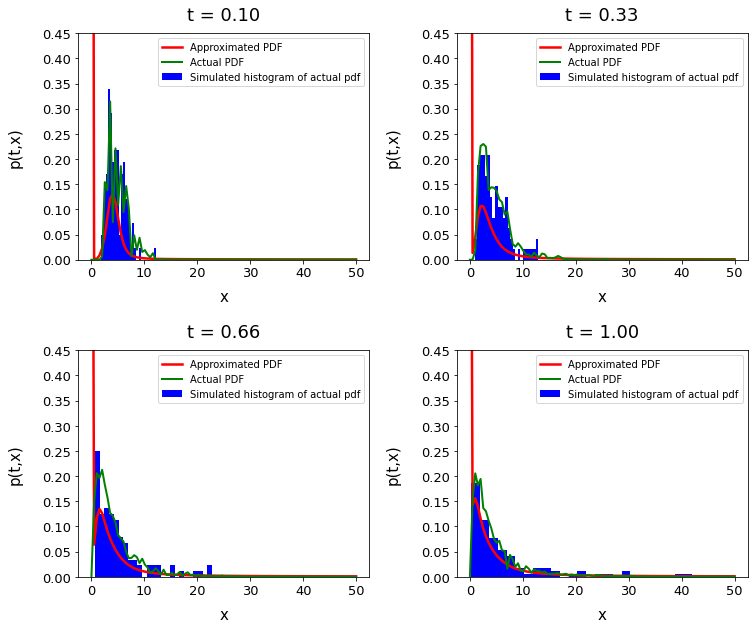

In [ ]:
plt.figure()
plt.figure(figsize = (12,10))

# time values at which to examine density
densityTimes = [0+0.1, 0.33*T, 0.66*T, T]
n_sim = 100
# vector of x values for plotting 
x_plot = np.linspace(Xlow*x_multiplier, Xhigh*x_multiplier, n_sim)

for i, curr_t in enumerate(densityTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    sim_x, mu, sigma = simulateGBM_GaussianStart(alpha, beta, m, s, n_sim, curr_t)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(x_plot.reshape(-1,1))
    unnorm_dens = sess.run([p_unnorm], feed_dict= {t_tnsr:t_plot, x_interior_tnsr:np.log(x_plot.reshape(-1,1))})
    density = unnorm_dens[0] / sp.integrate.simps(unnorm_dens[0].reshape(x_plot.shape), x_plot)
    # plot histogram of simulated process values and overlay estimated density
    count, bins, ignored = plt.hist(sim_x, bins=25, density=True, color = 'b', label='Simulated histogram of actual pdf')
    plt.plot(x_plot, density, 'r', linewidth=2.5, label='Approximated PDF')
    
    
    x = np.linspace(1e-2, 50, n_sim)

#print(x)
    pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))


    plt.plot(x, pdf, linewidth=2, color='green', label='Actual PDF')
    plt.axis('tight')   

    # subplot options
    plt.ylim(ymin=0.0, ymax=0.45)
    plt.xlabel(r"x", fontsize=15, labelpad=10)
    plt.ylabel(r"p(t,x)", fontsize=15, labelpad=20)
    plt.title(r"t = %.2f"%(curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(loc="upper right")
# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

if saveFigure:
    plt.savefig(figureName)